# Import

In [1]:
# from kaggle.api.kaggle_api_extended import KaggleApi

In [2]:
# !kaggle datasets download -d ekibee/synthetic-dataset-for-object-detection

In [3]:
# !unzip synthetic-dataset-for-object-detection

In [4]:
# !pip install -q git+https://github.com/tensorflow/examples.git

In [1]:
import skimage
import skimage.io
import os
from tqdm.notebook import tqdm
import numpy as np

In [2]:
# ImgDir = "dual_real_2/"
# labels = os.listdir(f"{ImgDir}labels/images/")
# len(labels)
# sch = 0
# for l_name in tqdm(labels, total=len(labels)):
#     sch+=1
#     l_name = ImgDir + 'labels/images/' + l_name
# #     img = skimage.io.imread(l_name,as_gray=True)
#     img = skimage.io.imread(l_name,as_gray=True)
# #     print(np.unique(img))
# #     img = cv2.resize(img,dsize=(128,128),interpolation=cv2.INTER_CUBIC)
    
# #             cv2.resize(
# #             cv2.imread(f'{obj_path}labels/images/' + file, cv2.IMREAD_GRAYSCALE),
# #             dsize=(IMG_HEIGHT, IMG_WIDTH),
# #             interpolation=cv2.INTER_CUBIC
# #         ),
# #     print(np.unique(img))
# #     k =100
# #     img[img<k]=0
# #     img[img>k]=255
# #     print(np.unique(img))
# #     plt.imshow(img)
# #     sleep(10)
# #     if sch > 20:
# #         break
# #     img = np.uint8(img*255)
# #     print(np.unique(img))
# #     img[img < 255] = 0
# #     print(np.unique(img))
# #     break
#     skimage.io.imsave(l_name, img)
# #     print(np.unique(img))
# #     break
# #     img = np.uint8(img*255)
# #     skimage.io.imsave(l_name, img)

# # len(labels)


# # my_f = skimage.io.imread(my_img, as_gray=True)
# # my_f = np.uint8(my_f*255)
# # # my_f = np.uint8(np.where(my_f > 0.8, 255, 0))
# # plt.imshow()

In [3]:
import tensorflow as tf
from tensorflow_examples.models.pix2pix import pix2pix
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tqdm.notebook import tqdm
import numpy as np
import cv2

import os

from IPython.display import clear_output
import matplotlib.pyplot as plt

## Load Data

In [4]:
def normalize(input_image):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    return input_image

def normalize_mask(input_image):
    k = 200
    input_image[input_image < k] = 0
    input_image[input_image > k] = 255
    input_image = tf.cast(input_image, tf.float32) / 255.0
    return input_image

The dataset already contains the required splits of test and train and so let's continue to use the same split.

In [5]:
IMG_HEIGHT = 128
IMG_WIDTH = 128
BATCH_SIZE = 32
obj_path = 'Cube/combo/'

In [6]:
image_dataset = np.array([
    cv2.resize(cv2.imread(f'{obj_path}features/images/' + file), dsize=(IMG_HEIGHT, IMG_WIDTH), interpolation=cv2.INTER_CUBIC)
    for file in tqdm(os.listdir(f'{obj_path}features/images/'))])

mask_dataset = np.array([
    np.expand_dims(
        cv2.resize(
            cv2.imread(f'{obj_path}labels/images/' + file, cv2.IMREAD_GRAYSCALE),
            dsize=(IMG_HEIGHT, IMG_WIDTH),
            interpolation=cv2.INTER_CUBIC
        ),
        axis=2
    ) for file in tqdm(os.listdir(f'{obj_path}labels/images/'))])

image_for_test = np.array([
    cv2.resize(cv2.imread(f'{obj_path}/image_for_test/' + file), dsize=(IMG_HEIGHT, IMG_WIDTH), interpolation=cv2.INTER_CUBIC)
    for file in tqdm(os.listdir(f'{obj_path}/image_for_test/'))])

  0%|          | 0/4093 [00:00<?, ?it/s]

  0%|          | 0/4093 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [7]:
ImgDir = f'{obj_path}/image_for_test/'
image_for_test = os.listdir(f"{ImgDir}")
imgs = []
for i in image_for_test:
    o = cv2.resize(cv2.imread(f'{ImgDir}' + i),
               dsize=(IMG_HEIGHT, IMG_WIDTH),
               interpolation=cv2.INTER_CUBIC)
    o = cv2.cvtColor(o, cv2.COLOR_BGR2RGB)
    imgs.append(o)
    

In [8]:
data_gen_args = dict(
    horizontal_flip=True,
    vertical_flip=True,
# #     channel_shift_range=100,
    
#     rotation_range=90,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     zoom_range=0.2,
)

image_datagen = ImageDataGenerator(**data_gen_args, preprocessing_function=normalize, validation_split=0.2)
mask_datagen = ImageDataGenerator(**data_gen_args, preprocessing_function=normalize_mask, validation_split=0.2)
image_for_test_datagen = ImageDataGenerator(preprocessing_function=normalize)

seed = 1046527

image_datagen.fit(image_dataset[:90], augment=True, seed=seed)
mask_datagen.fit(mask_dataset[:90], augment=True, seed=seed)

In [9]:
train_image_generator = image_datagen.flow_from_directory(
    f'./{obj_path}features',
    class_mode=None,
    seed=seed,
    batch_size=BATCH_SIZE,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    subset='training'
)

train_mask_generator = mask_datagen.flow_from_directory(
    f'./{obj_path}labels',
    class_mode=None,
    seed=seed,
    batch_size=BATCH_SIZE,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    color_mode='grayscale',
    subset='training'
)

train_generator = zip(train_image_generator, train_mask_generator)

valid_image_generator = image_datagen.flow_from_directory(
    f'./{obj_path}features',
    class_mode=None,
    seed=seed,
    batch_size=BATCH_SIZE,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    subset='validation'
)

valid_mask_generator = mask_datagen.flow_from_directory(
    f'./{obj_path}labels',
    class_mode=None,
    seed=seed,
    batch_size=BATCH_SIZE,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    color_mode='grayscale',
    subset='validation'
)

valid_generator = zip(valid_image_generator, valid_mask_generator)

image_for_test_generator = image_for_test_datagen.flow_from_directory(
    f'{obj_path}image_for_test_dg/',
    class_mode=None,
    seed=seed,
    batch_size=1,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    subset='training'
)

Found 3275 images belonging to 1 classes.
Found 3275 images belonging to 1 classes.
Found 818 images belonging to 1 classes.
Found 818 images belonging to 1 classes.
Found 12 images belonging to 1 classes.


Let's take a look at an image example and it's correponding mask from the dataset.

In [10]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

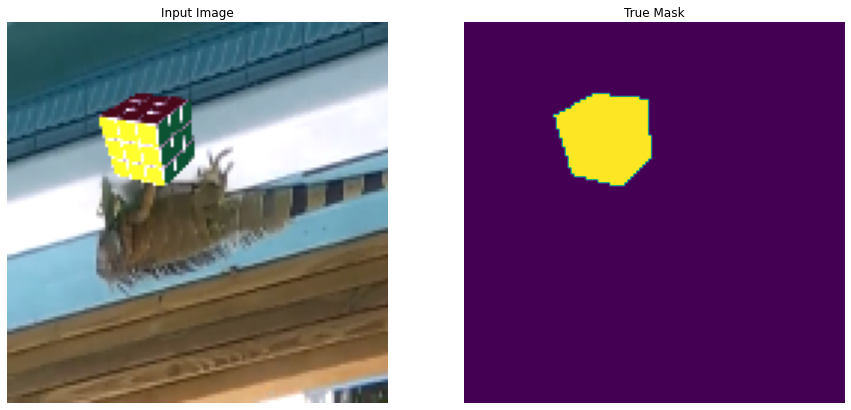

In [23]:
for image, mask in train_generator:
    sample_image, sample_mask = image[0], mask[0]
    break
display([sample_image, sample_mask])

## Define the model
The model being used here is a modified U-Net. A U-Net consists of an encoder (downsampler) and decoder (upsampler). In-order to learn robust features, and reduce the number of trainable parameters, a pretrained model can be used as the encoder. Thus, the encoder for this task will be a pretrained MobileNetV2 model, whose intermediate outputs will be used, and the decoder will be the upsample block already implemented in TensorFlow Examples in the [Pix2pix tutorial](https://github.com/tensorflow/examples/blob/master/tensorflow_examples/models/pix2pix/pix2pix.py). 

The reason to output three channels is because there are three possible labels for each pixel. Think of this as multi-classification where each pixel is being classified into three classes.

As mentioned, the encoder will be a pretrained MobileNetV2 model which is prepared and ready to use in [tf.keras.applications](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/applications). The encoder consists of specific outputs from intermediate layers in the model. Note that the encoder will not be trained during the training process.

In [24]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[IMG_HEIGHT, IMG_WIDTH, 3], include_top=False, classes=2)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

In [25]:
# base_model.get_config()

The decoder/upsampler is simply a series of upsample blocks implemented in TensorFlow examples.

In [26]:
up_stack = [
    pix2pix.upsample(1536, 3),  # 4x4 -> 8x8
    pix2pix.upsample(768, 3),  # 8x8 -> 16x16
    pix2pix.upsample(384, 3),  # 16x16 -> 32x32
    pix2pix.upsample(196, 3),   # 32x32 -> 64x64
]

In [27]:
def unet_model(output_channels):
    inputs = tf.keras.layers.Input(shape=[IMG_HEIGHT, IMG_WIDTH, 3])

    # Downsampling through the model
    skips = down_stack(inputs)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(
        output_channels,
        3,
        strides=2,
        activation='sigmoid',
        padding='same')  # 64x64 -> 128x128

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [28]:
from tensorflow.keras import backend as K


def jaccard_distance(y_true, y_pred, smooth=100):

    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac) * smooth


def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
    return dice

def recall_m(y_true, y_pred):
    y_true = K.ones_like(y_true) 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    all_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    
    recall = true_positives / (all_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    y_true = K.ones_like(y_true) 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

## Train the model
Now, all that is left to do is to compile and train the model. The loss being used here is `losses.SparseCategoricalCrossentropy(from_logits=True)`. The reason to use this loss function is because the network is trying to assign each pixel a label, just like multi-class prediction. In the true segmentation mask, each pixel has either a {0,1,2}. The network here is outputting three channels. Essentially, each channel is trying to learn to predict a class, and `losses.SparseCategoricalCrossentropy(from_logits=True)` is the recommended loss for 
such a scenario. Using the output of the network, the label assigned to the pixel is the channel with the highest value. This is what the create_mask function is doing.

In [29]:
model = unet_model(1)
model.compile(optimizer='adam',
              loss=jaccard_distance,
              metrics=['accuracy', tf.keras.metrics.MeanIoU(num_classes=2), dice_coef, f1_score])

In [30]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
model (Functional)              [(None, 64, 64, 96), 1841984     input_2[0][0]                    
__________________________________________________________________________________________________
sequential (Sequential)         (None, 8, 8, 1536)   4429824     model[0][4]                      
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 8, 8, 2112)   0           sequential[0][0]                 
                                                                 model[0][3]                

Have a quick look at the resulting model architecture:

In [31]:
tf.keras.utils.plot_model(model, show_shapes=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


Let's try out the model to see what it predicts before training.

In [32]:
def create_mask(pred_mask):
#     pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[:,:,:,0]
    pred_mask = tf.round(pred_mask)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [33]:
def show_predictions(dataset=None, num=1):
    if dataset:
        i = 0
        for image, mask in dataset:
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
            i += 1
            if i == num:
                break
    else:
        
        display([sample_image, sample_mask,
                 create_mask(model.predict(sample_image[tf.newaxis, ...]))])

In [34]:
def pred(img,mode, cont=False):
    color = (256, 0, 256)
    pred = create_mask(mode.predict(img[tf.newaxis, ...]))
    pred = pred[:, :,0].numpy()
    pred[pred>0] = 255
    pred = np.stack((pred,) * 3, axis=-1)
    pred = np.uint8(pred*255)
    pred = cv2.cvtColor(pred, cv2.COLOR_BGR2GRAY)
#     print(np.unique(pred))
    
    contours, hierarchy = cv2.findContours(pred, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if cont:
        try:
            cv2.drawContours(pred, [max(contours, key = cv2.contourArea)], -1, cv2.FILLED, 8)
            cv2.fillPoly(pred, pts=[max(contours, key = cv2.contourArea)], color=color)
        except:
            print('Contours not found!')
            cv2.drawContours(pred, contours, -1, cv2.FILLED, 8)
            cv2.fillPoly(pred, pts=contours, color=color)
    else:
        cv2.drawContours(pred, contours, -1, cv2.FILLED, 8)
        cv2.fillPoly(pred, pts=contours, color=color)
    
    return pred

def show_fm():
    img = next(image_for_test_generator)
    img = img[0]
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'Model Mask', 'Contour Mask']
    s_pred = pred(img, model, False)
    c_pred = pred(img, model, True)
    sh = (img, s_pred,c_pred)
    
    for i in range(len(sh)):
        plt.subplot(1, len(sh), i+1)
        plt.title(title[i])
#         plt.imshow(sh[i],cmap='gray')
        plt.imshow(sh[i])
        plt.axis('off')
    plt.show()
 

In [35]:
# model.

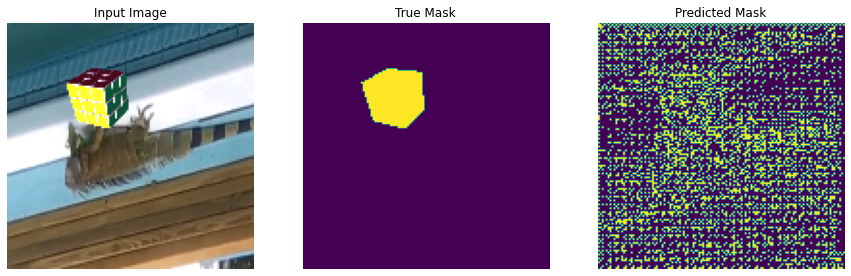

In [36]:
show_predictions()

Let's observe how the model improves while it is training. To accomplish this task, a callback function is defined below. 

In [37]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
#         clear_output(wait=True)
        show_fm()
        show_fm() 
        show_fm() 
        show_predictions()
        print('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [38]:
# model_path = 'ready_models/dual_synt_3'

# model = tf.keras.models.load_model(filepath=model_path,compile=False)
# model.compile(optimizer='adam',
              
# #               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              
#               loss=jaccard_distance,
#               metrics=['accuracy', tf.keras.metrics.MeanIoU(num_classes=2), dice_coef, f1_score])

Epoch 1/10
300/300 [==============================] - 171s 572ms/step - loss: 0.0123 - accuracy: 0.9876 - mean_io_u: 0.8431 - dice_coef: 0.8495 - f1_score: 0.0684 - val_loss: 0.0197 - val_accuracy: 0.9802 - val_mean_io_u: 0.7820 - val_dice_coef: 0.7863 - val_f1_score: 0.0704


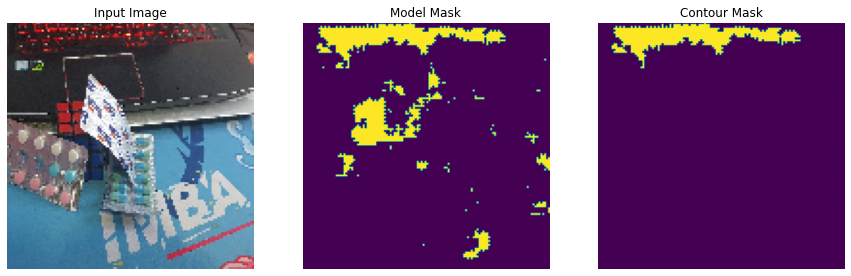

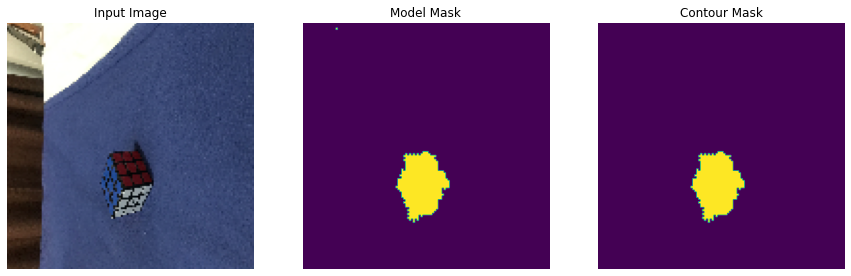

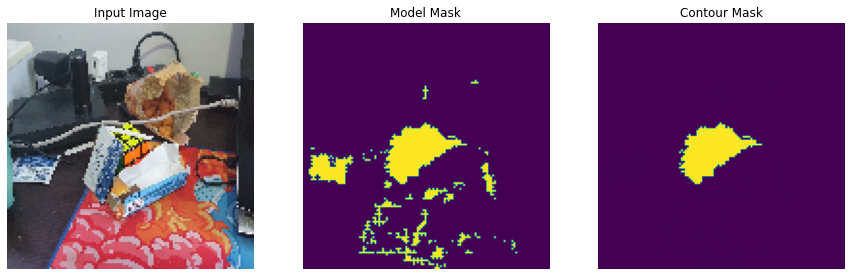

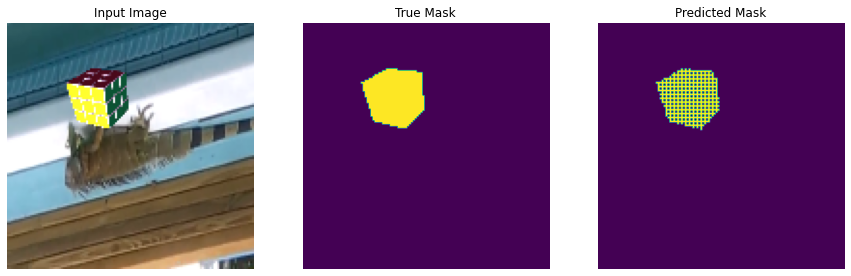


Sample Prediction after epoch 1

Epoch 2/10
300/300 [==============================] - 165s 551ms/step - loss: 0.0124 - accuracy: 0.9875 - mean_io_u: 0.8427 - dice_coef: 0.8483 - f1_score: 0.0685 - val_loss: 0.0200 - val_accuracy: 0.9799 - val_mean_io_u: 0.7807 - val_dice_coef: 0.7864 - val_f1_score: 0.0706


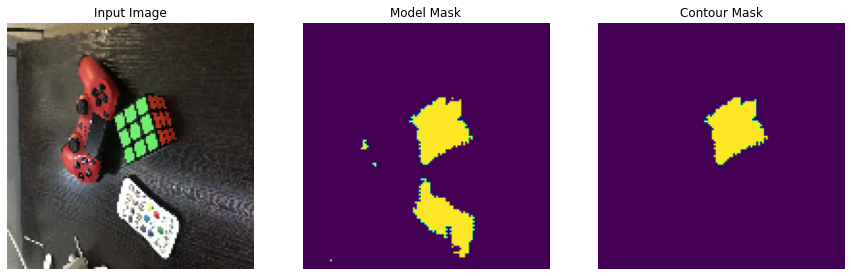

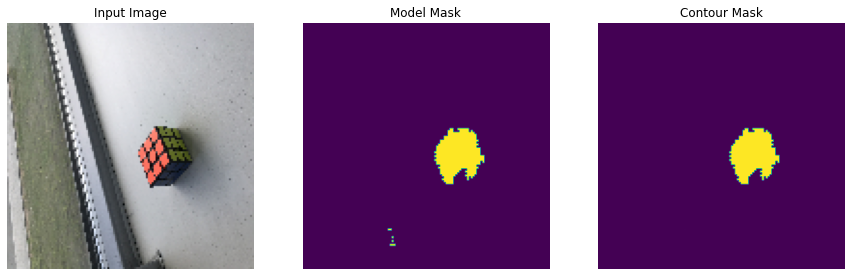

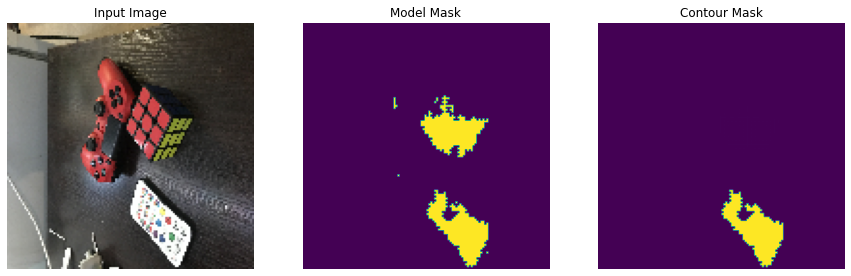

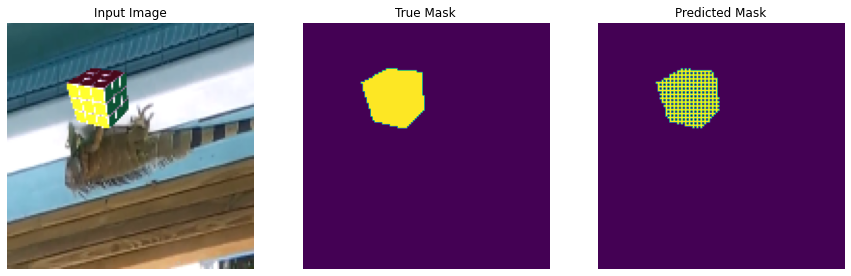


Sample Prediction after epoch 2

Epoch 3/10
300/300 [==============================] - 177s 592ms/step - loss: 0.0124 - accuracy: 0.9875 - mean_io_u: 0.8434 - dice_coef: 0.8486 - f1_score: 0.0684 - val_loss: 0.0198 - val_accuracy: 0.9800 - val_mean_io_u: 0.7861 - val_dice_coef: 0.7886 - val_f1_score: 0.0715


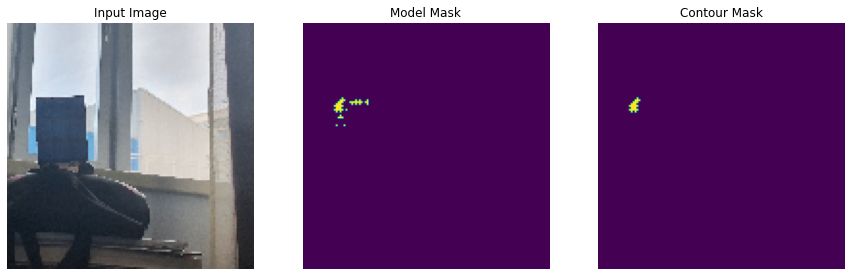

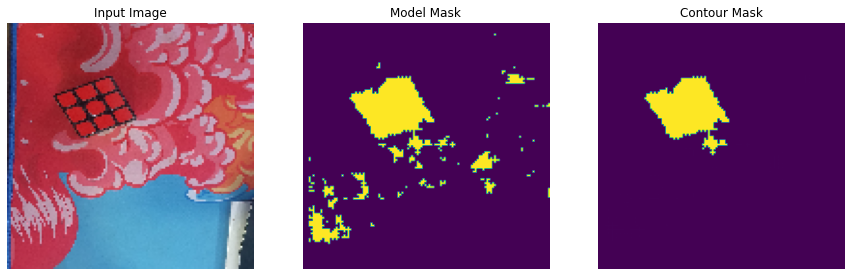

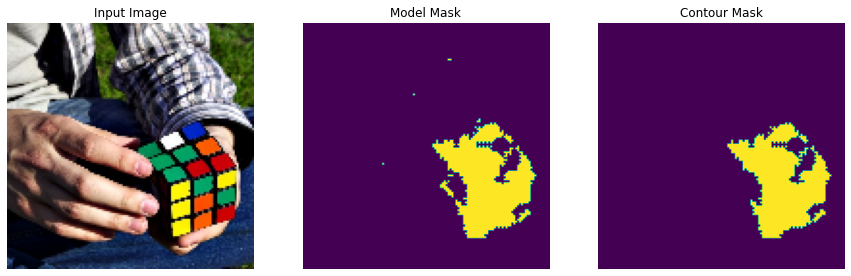

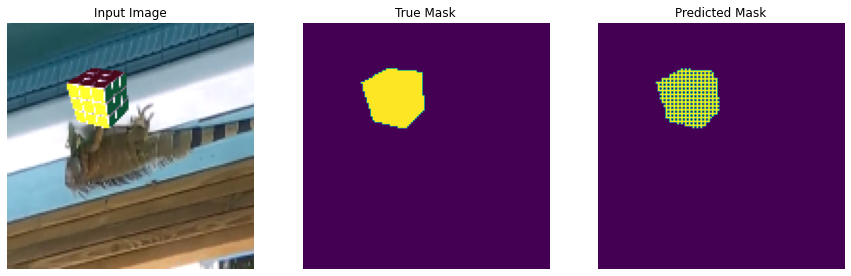


Sample Prediction after epoch 3

Epoch 4/10
300/300 [==============================] - 175s 585ms/step - loss: 0.0124 - accuracy: 0.9875 - mean_io_u: 0.8441 - dice_coef: 0.8489 - f1_score: 0.0684 - val_loss: 0.0200 - val_accuracy: 0.9798 - val_mean_io_u: 0.7755 - val_dice_coef: 0.7786 - val_f1_score: 0.0681


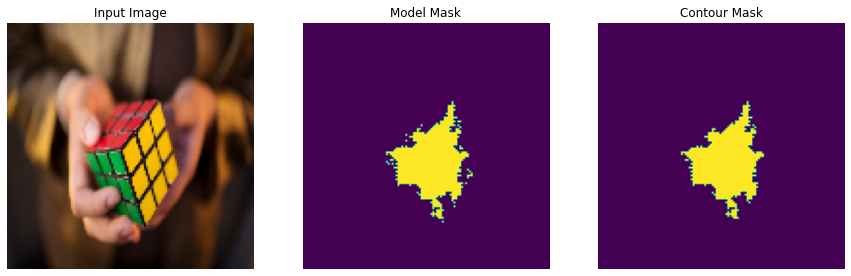

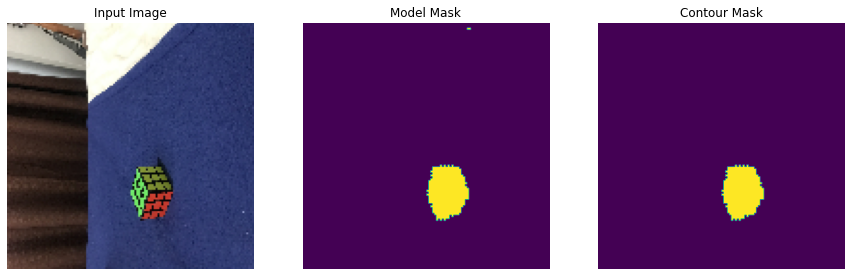

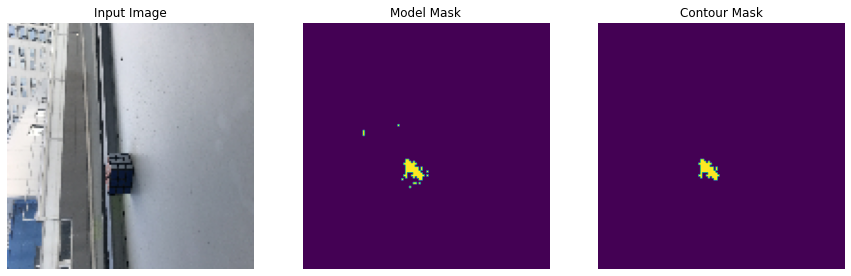

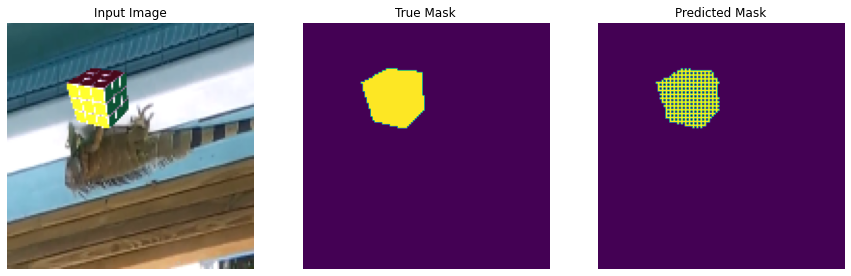


Sample Prediction after epoch 4

Epoch 5/10
300/300 [==============================] - 171s 570ms/step - loss: 0.0124 - accuracy: 0.9875 - mean_io_u: 0.8448 - dice_coef: 0.8488 - f1_score: 0.0685 - val_loss: 0.0190 - val_accuracy: 0.9809 - val_mean_io_u: 0.7951 - val_dice_coef: 0.7927 - val_f1_score: 0.0725


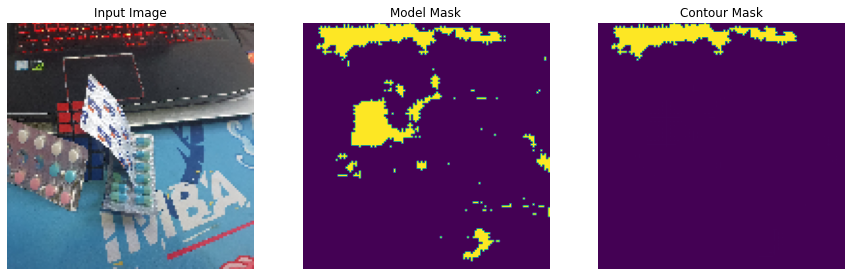

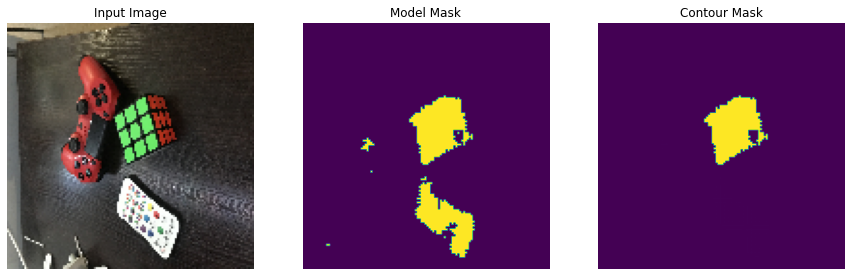

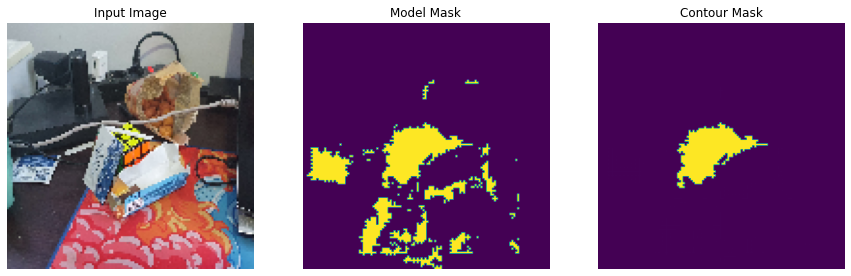

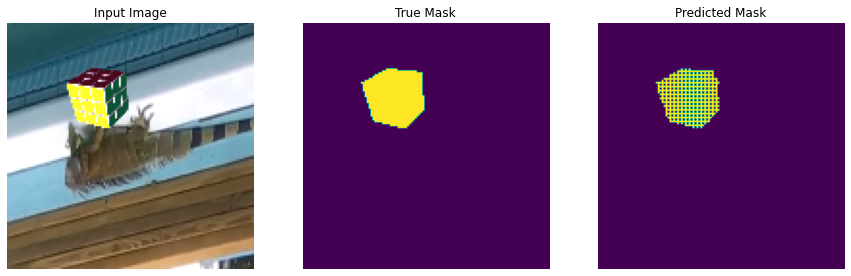


Sample Prediction after epoch 5

Epoch 6/10
300/300 [==============================] - 173s 578ms/step - loss: 0.0123 - accuracy: 0.9876 - mean_io_u: 0.8451 - dice_coef: 0.8488 - f1_score: 0.0683 - val_loss: 0.0197 - val_accuracy: 0.9801 - val_mean_io_u: 0.7814 - val_dice_coef: 0.7873 - val_f1_score: 0.0698


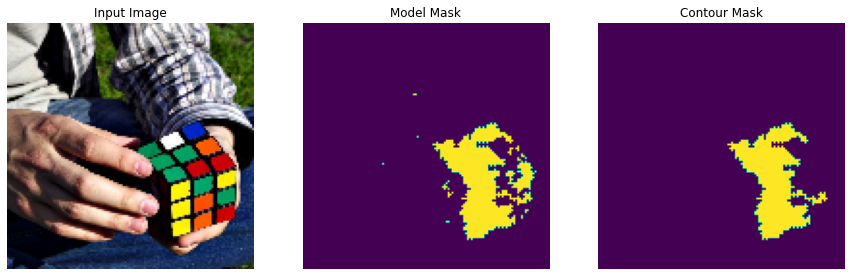

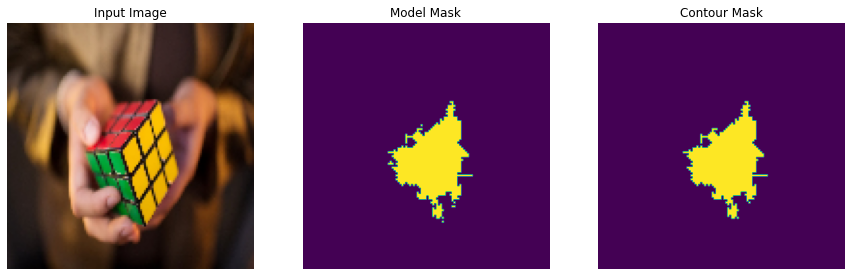

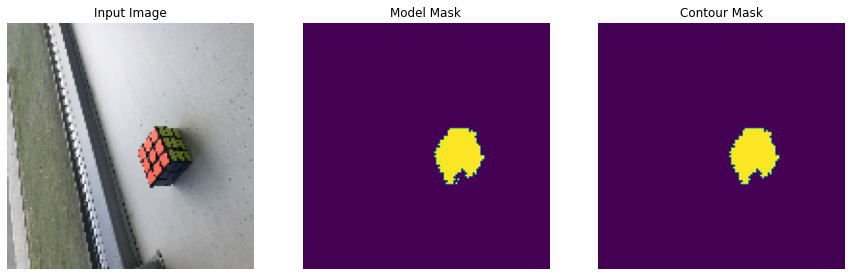

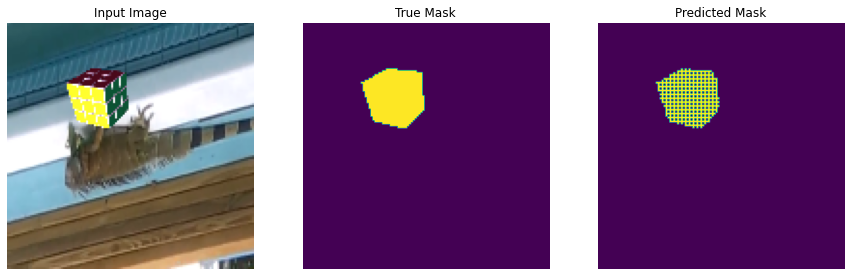


Sample Prediction after epoch 6

Epoch 7/10
300/300 [==============================] - 172s 574ms/step - loss: 0.0123 - accuracy: 0.9876 - mean_io_u: 0.8460 - dice_coef: 0.8493 - f1_score: 0.0684 - val_loss: 0.0204 - val_accuracy: 0.9795 - val_mean_io_u: 0.7797 - val_dice_coef: 0.7813 - val_f1_score: 0.0698


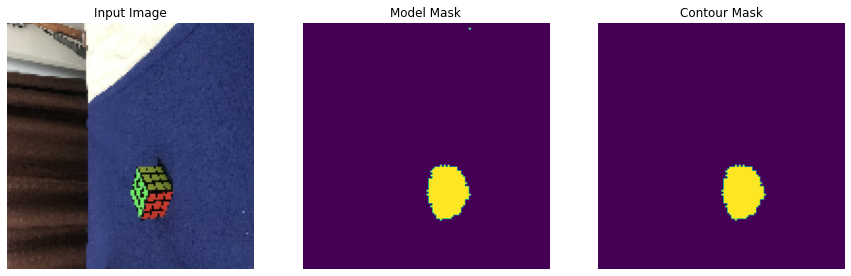

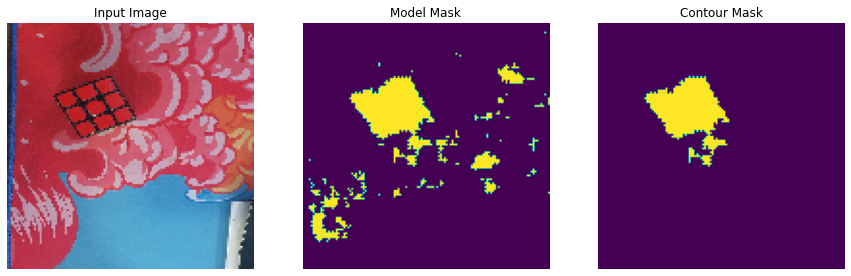

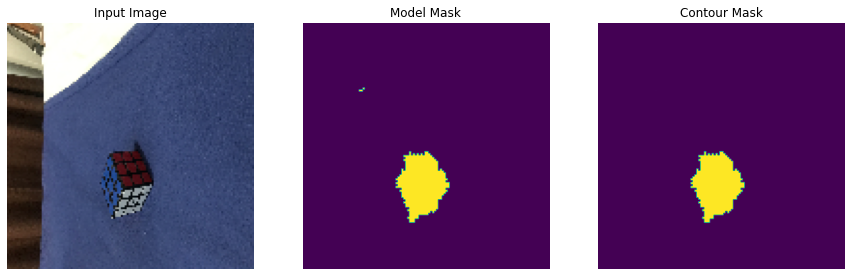

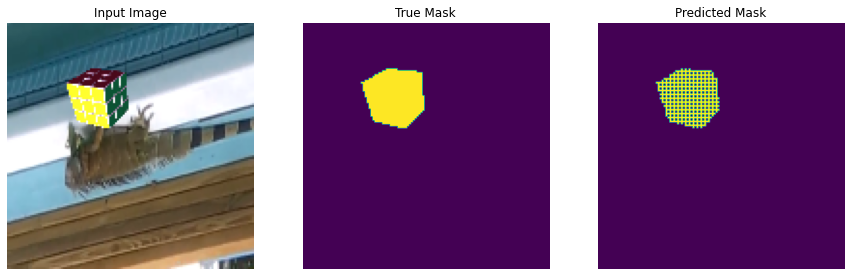


Sample Prediction after epoch 7

Epoch 8/10
300/300 [==============================] - 175s 585ms/step - loss: 0.0123 - accuracy: 0.9876 - mean_io_u: 0.8462 - dice_coef: 0.8494 - f1_score: 0.0684 - val_loss: 0.0197 - val_accuracy: 0.9801 - val_mean_io_u: 0.7874 - val_dice_coef: 0.7889 - val_f1_score: 0.0712


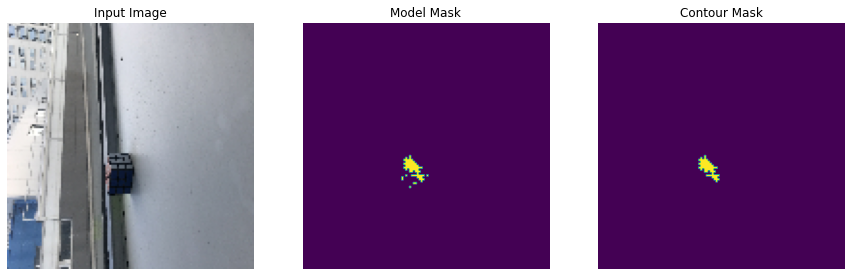

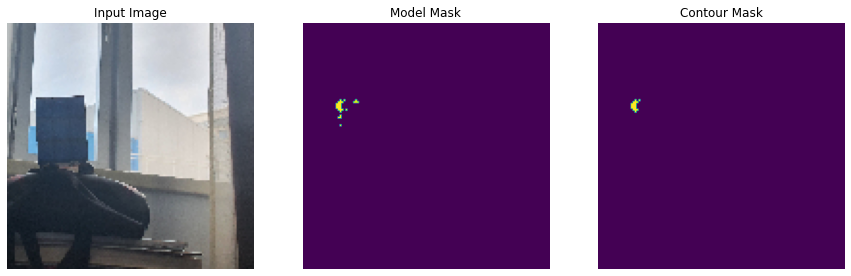

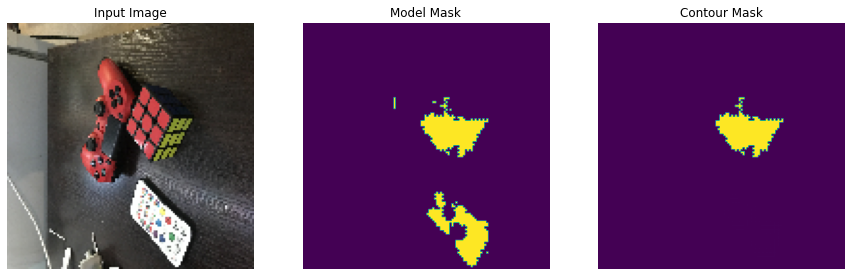

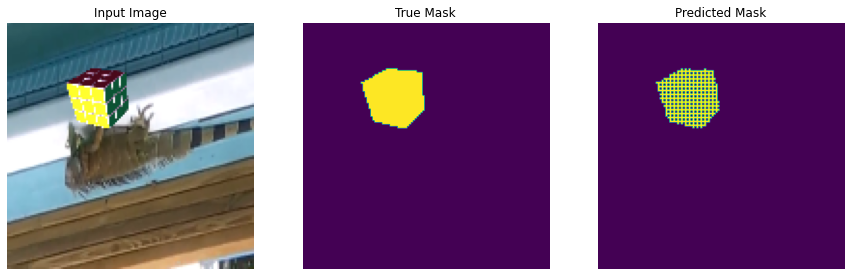


Sample Prediction after epoch 8

Epoch 9/10
300/300 [==============================] - 173s 579ms/step - loss: 0.0123 - accuracy: 0.9876 - mean_io_u: 0.8465 - dice_coef: 0.8495 - f1_score: 0.0684 - val_loss: 0.0202 - val_accuracy: 0.9797 - val_mean_io_u: 0.7817 - val_dice_coef: 0.7810 - val_f1_score: 0.0701


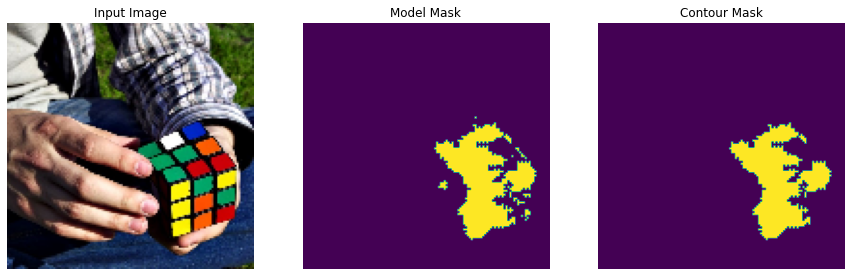

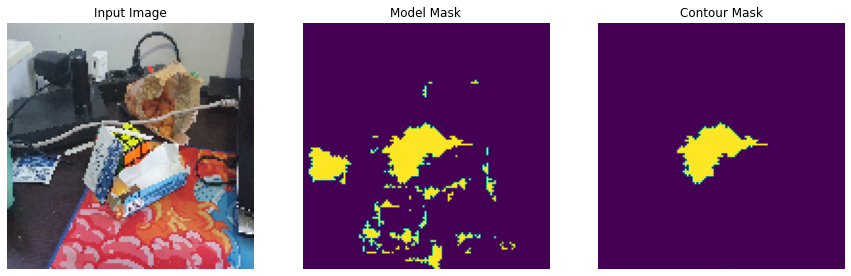

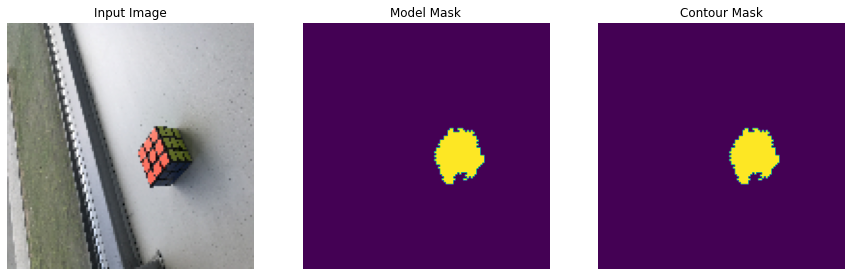

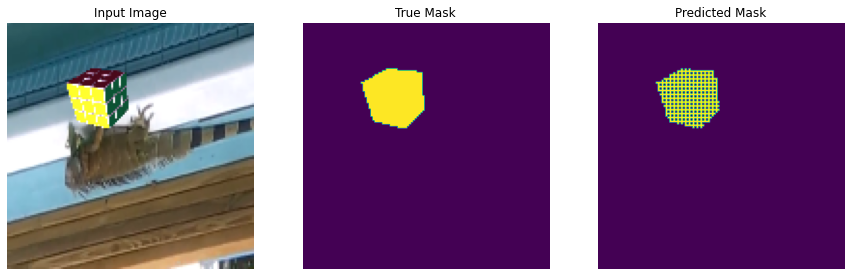


Sample Prediction after epoch 9

Epoch 10/10
300/300 [==============================] - 164s 548ms/step - loss: 0.0123 - accuracy: 0.9876 - mean_io_u: 0.8472 - dice_coef: 0.8497 - f1_score: 0.0684 - val_loss: 0.0199 - val_accuracy: 0.9799 - val_mean_io_u: 0.7868 - val_dice_coef: 0.7833 - val_f1_score: 0.0708


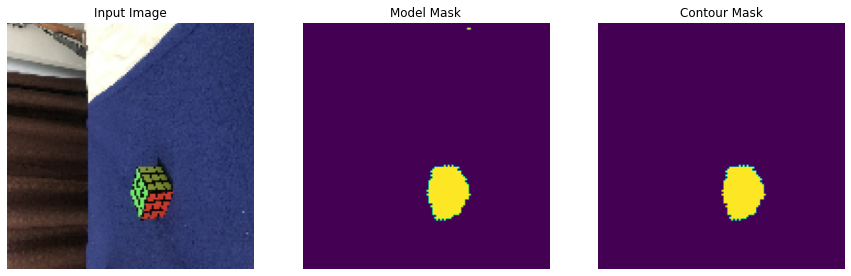

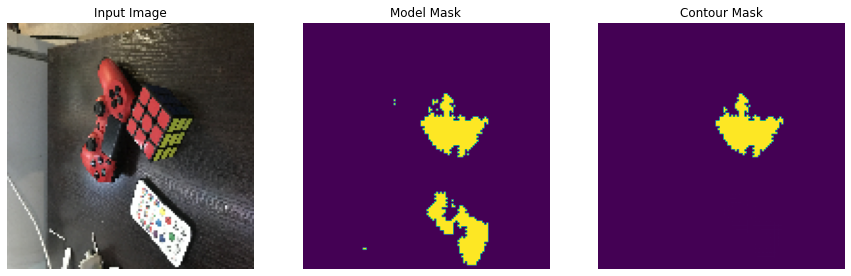

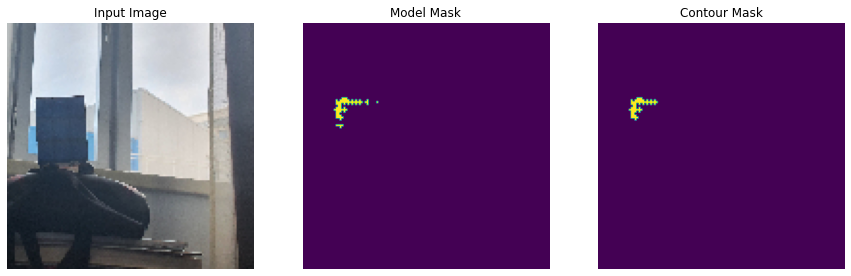

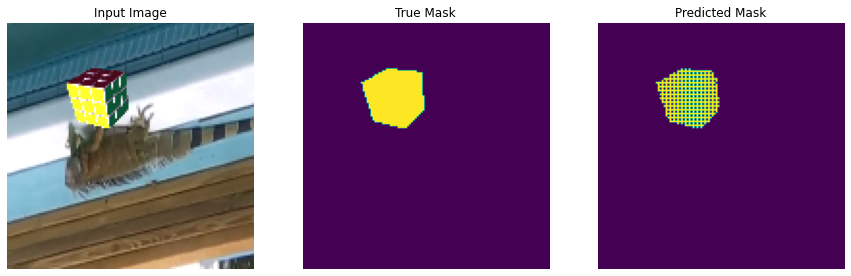


Sample Prediction after epoch 10



In [43]:
EPOCHS = 10
VALIDATION_STEPS = 30
STEPS_PER_EPOCH = 300

model_history = model.fit(
    train_generator,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_steps=VALIDATION_STEPS,
    validation_data=valid_generator,
    callbacks=[DisplayCallback()],
#     class_weight=class_weight,
)

In [44]:
model.save('ready_models/' + 'cube_combo_50/')

C:\Users\KiBee\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: ready_models/cube_combo_50/assets


In [ ]:
eval_obj_path = 'sofa_real/'

In [ ]:
eval_image_dataset = np.array([
    cv2.resize(cv2.imread(f'{eval_obj_path}features/images/' + file), dsize=(IMG_HEIGHT, IMG_WIDTH), interpolation=cv2.INTER_CUBIC)
    for file in tqdm(os.listdir(f'{eval_obj_path}features/images/'))])

eval_mask_dataset = np.array([
    np.expand_dims(
        cv2.resize(
            cv2.imread(f'{eval_obj_path}labels/images/' + file, cv2.IMREAD_GRAYSCALE),
            dsize=(IMG_HEIGHT, IMG_WIDTH),
            interpolation=cv2.INTER_CUBIC
        ),
        axis=2
    ) for file in tqdm(os.listdir(f'{eval_obj_path}labels/images/'))])

# eval_image_for_test = np.array([
#     cv2.resize(cv2.imread(f'{obj_path}/image_for_test/' + file), dsize=(IMG_HEIGHT, IMG_WIDTH), interpolation=cv2.INTER_CUBIC)
#     for file in tqdm(os.listdir(f'{obj_path}/image_for_test/'))])

In [ ]:
data_gen_args = dict(
#     horizontal_flip=True,
#     vertical_flip=True,
# #     channel_shift_range=100,
    
#     rotation_range=90,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     zoom_range=0.2,
)

eval_image_datagen = ImageDataGenerator(**data_gen_args, preprocessing_function=normalize, validation_split=0.1)
eval_mask_datagen = ImageDataGenerator(**data_gen_args, preprocessing_function=normalize_mask, validation_split=0.1)
image_for_test_datagen = ImageDataGenerator(preprocessing_function=normalize)

seed = 1046527

eval_image_datagen.fit(eval_image_dataset[:90], augment=True, seed=seed)
eval_mask_datagen.fit(eval_mask_dataset[:90], augment=True, seed=seed)

In [ ]:
eval_train_image_generator = eval_image_datagen.flow_from_directory(
    f'./{eval_obj_path}features',
    class_mode=None,
    seed=seed,
    batch_size=1,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    subset='validation'
)

eval_train_mask_generator = eval_mask_datagen.flow_from_directory(
    f'./{eval_obj_path}labels',
    class_mode=None,
    seed=seed,
    batch_size=1,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    color_mode='grayscale',
    subset='validation'
)

eval_train_generator = zip(eval_train_image_generator, eval_train_mask_generator)

# valid_image_generator = image_datagen.flow_from_directory(
#     f'./{obj_path}features',
#     class_mode=None,
#     seed=seed,
#     batch_size=BATCH_SIZE,
#     target_size=(IMG_HEIGHT, IMG_WIDTH),
#     subset='validation'
# )

# valid_mask_generator = mask_datagen.flow_from_directory(
#     f'./{obj_path}labels',
#     class_mode=None,
#     seed=seed,
#     batch_size=BATCH_SIZE,
#     target_size=(IMG_HEIGHT, IMG_WIDTH),
#     color_mode='grayscale',
#     subset='validation'
# )

# valid_generator = zip(valid_image_generator, valid_mask_generator)

# image_for_test_generator = image_for_test_datagen.flow_from_directory(
#     f'{obj_path}image_for_test_dg/',
#     class_mode=None,
#     seed=seed,
#     batch_size=1,
#     target_size=(IMG_HEIGHT, IMG_WIDTH),
#     subset='training'
# )

In [ ]:
eval_ = []
for i in range(50):
    eval_.append(next(eval_train_generator))

In [ ]:
def show_fm2(imgs):
#     img = next(image_for_test_generator)
    img = imgs[0][0]
#     print(img.shape)
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'Model Mask', 'Contour Mask']
    s_pred = imgs[1][0]
    c_pred = pred(img, model, False)
    sh = (img, s_pred,c_pred)
    
    for i in range(len(sh)):
        plt.subplot(1, len(sh), i+1)
        plt.title(title[i])
#         plt.imshow(sh[i],cmap='gray')
        plt.imshow(sh[i])
        plt.axis('off')
    plt.show()


In [ ]:

# plt.imshow()
for i in range(20):
    g = eval_[i]
    show_fm2(g)

    model.evaluate(g[0],g[1],steps=1,verbose=2)

In [ ]:
model_history.history

In [ ]:
plt.imshow(model.predict(image)[3])

In [ ]:
model.summary()

In [ ]:
# loss = model_history.history['accuracy']
# val_loss = model_history.history['val_accuracy']

# plt.figure(figsize=(15,15))
# plt.plot(model_history.epoch, loss, 'r', label='Training loss')
# plt.plot(model_history.epoch, val_loss, 'bo', label='Validation loss')
# plt.title('Training and Validation Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss Value')
# plt.ylim([0, 1])
# plt.legend()
# plt.show()

In [ ]:
print('ok')

## Make predictions

Let's make some predictions. In the interest of saving time, the number of epochs was kept small, but you may set this higher to achieve more accurate results.

In [ ]:
show_predictions(valid_generator, 10)

In [ ]:
# model.save('sofa_light_230ep')

In [ ]:
test = []

for i in tqdm(range(30)):
    test.append(valid_generator)

In [ ]:
for i in test:
    show_predictions(i)
    

## Optional: Imbalanced classes and class weights

Semantic segmentation datasets can be highly imbalanced meaning that particular class pixels can be present more inside images than that of other classes. Since segmentation problems can be treated as per-pixel classification problems we can deal with the imbalance problem by weighing the loss function to account for this. It's a simple and elegant way to deal with this problem. See the [imbalanced classes tutorial](https://www.tensorflow.org/tutorials/structured_data/imbalanced_data).

To [avoid ambiguity](https://github.com/keras-team/keras/issues/3653#issuecomment-243939748), `Model.fit` does not support the `class_weight` argument for inputs with 3+ dimensions.

In [ ]:
# weight_for_0 = (1 / 80) * (100 / 2.0)
# weight_for_1 = (1 / 20) * (100 / 2.0)

# class_weight = {0: weight_for_0, 1: weight_for_1}

# try:
#     model_history = model.fit(
#         train_dataset,
#         epochs=EPOCHS,
#         steps_per_epoch=STEPS_PER_EPOCH,
#         class_weight=class_weight
#     )
#     assert False
# except Exception as e:
#     print(f"{type(e).__name__}: {e}")

In [ ]:
# weighted_model = unet_model(OUTPUT_CHANNELS)
# weighted_model.compile(
#     optimizer='adam',
#     loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#     metrics=['accuracy'])

In [ ]:
# weighted_model.fit(
#     train_dataset.map(add_sample_weights),
#     epochs=1,
#     steps_per_epoch=10,
# )

In [ ]:
import cv2
import numpy as np
import tensorflow as tf
import pandas as pd
from skimage.measure import label, regionprops
from skimage.transform import resize
import scipy.misc
# from keras.preprocessing.image import array_to_img


# IMG_HEIGHT = 256
# IMG_WIDTH = 256


# model = tf.keras.models.load_model('good_model_384')


In [ ]:
# IMG_HEIGHT, IMG_WIDTH = model.get_config()['layers'][0]['config']['batch_input_shape'][1:3]

# ImgDir = f'{obj_path}/image_for_test/'
# image_for_test = os.listdir(f"{ImgDir}")
# imgs = []
# for i in image_for_test:
#     o = cv2.resize(cv2.imread(f'{ImgDir}' + i),
#                dsize=(IMG_HEIGHT, IMG_WIDTH),
#                interpolation=cv2.INTER_CUBIC)
#     o = cv2.cvtColor(o, cv2.COLOR_BGR2RGB)
#     imgs.append(o)

In [ ]:
IMG_HEIGHT, IMG_WIDTH = model.get_config()['layers'][0]['config']['batch_input_shape'][1:3]

ImgDir = f'{obj_path}/image_for_test/'
image_for_test = os.listdir(f"{ImgDir}")
imgs = []
for i in image_for_test:
    ob = cv2.imread(f'{ImgDir}' + i)
    ob = cv2.cvtColor(ob, cv2.COLOR_BGR2RGB)
    imgs.append(ob)

In [ ]:
# test_img = f'{obj_path}/image_for_test/00000168.jpg'
# test_img = cv2.imread(test_img)
# test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
# re_img = cv2.resize(test_img.copy(),
#                dsize=(IMG_HEIGHT, IMG_WIDTH),
#                interpolation=cv2.INTER_CUBIC)


def get_mask(img):
    test_img = img.copy()
    color = 200
    
    re_img = cv2.resize(test_img.copy(),
               dsize=(IMG_HEIGHT, IMG_WIDTH),
               interpolation=cv2.INTER_CUBIC)
    
    coef_y = test_img.shape[0] / re_img.shape[0]
    coef_x = test_img.shape[1] / re_img.shape[1]

    pred = re_img / 255.
    pred = create_mask(model.predict(pred[tf.newaxis, ...]))
    pred = pred[:, :,0].numpy()
    pred = np.stack((pred,) * 3, axis=-1)
    pred = np.uint8(pred*255)
    pred = cv2.cvtColor(pred, cv2.COLOR_BGR2GRAY)

    contours, hierarchy = cv2.findContours(pred, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        contour[:, :, 0] = contour[:, :, 0] * coef_x
        contour[:, :, 1] = contour[:, :,  1] * coef_y

    filled_img = cv2.drawContours(test_img, [max(contours, key = cv2.contourArea)], -1, 255, 1)
    filled_img = cv2.fillPoly(test_img.copy(), pts=[max(contours, key = cv2.contourArea)], color=color,)

#     filled_img = cv2.drawContours(test_img, contours, -1, 255, 1)
#     filled_img = cv2.fillPoly(test_img.copy(), pts=contours, color=color,)

    cv2.addWeighted(test_img, 0.5, filled_img, 0.5, 0, test_img)

    box = cv2.boundingRect(max(contours, key = cv2.contourArea))
    cv2.rectangle(test_img, box, color=color,thickness=4)

    plt.figure(figsize=(10, 10))
    plt.imshow(test_img)

In [ ]:
model.predict

In [ ]:
for i in imgs:
    get_mask(i)

In [ ]:
imgs = []
for i in image_for_test:
    o = cv2.resize(cv2.imread(f'{ImgDir}' + i),
               dsize=(IMG_HEIGHT, IMG_WIDTH),
               interpolation=cv2.INTER_CUBIC)
    o = cv2.cvtColor(o, cv2.COLOR_BGR2RGB)
    imgs.append(o)

In [ ]:
# model.save('good_model_sofa')

In [ ]:
imgs[2].shape

In [ ]:
def show_masked(img):
    color = (256, 0, 256)
    a = img.copy()
    pred = a/255.
    pred = create_mask(model.predict(pred[tf.newaxis, ...]))
    pred = pred[:, :,0].numpy()
    pred = np.stack((pred,) * 3, axis=-1)
    pred = np.uint8(pred*255)
    pred = cv2.cvtColor(pred, cv2.COLOR_BGR2GRAY)

    contours, hierarchy = cv2.findContours(pred, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#     cv2.drawContours(a, [max(contours, key = cv2.contourArea)], -1, cv2.FILLED, 8)
#     cv2.fillPoly(a, pts=[max(contours, key = cv2.contourArea)], color=color)
    cv2.fillPoly(a, pts=contours, color=color)
    return a


for i in range(len(imgs)):
    plt.figure(figsize=(8, 8))
    a = (show_masked(imgs[i]))
    plt.imshow(a)
    plt.axis('off')
    plt.show()
    
# for i in range(len(imgs)):
#     plt.subplot(i+1,1,)
#     show_masked(imgs[i])

In [ ]:
len(imgs)

In [ ]:
# or_model = tf.keras.models.load_model('good_model_orig_256')

In [ ]:
len(image_for_test)


image_for_test_datagen = ImageDataGenerator(preprocessing_function=normalize)

seed = 1

# image_for_test_datagen.fit(image_for_test, augment=False, seed=seed)

image_for_test_generator = image_for_test_datagen.flow_from_directory(
    f'{obj_path}image_for_test_dg/',
    class_mode=None,
    seed=seed,
    batch_size=1,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    subset='training'
)

tt = []
for i in range(20):
    tt.append(next(image_for_test_generator))

In [ ]:
def pred(img,mode, cont=False):
    color = (256, 0, 256)
    pred = create_mask(mode.predict(img[tf.newaxis, ...]))
    pred = pred[:, :,0].numpy()
    
    pred[pred>0] = 255
    
    pred = np.stack((pred,) * 3, axis=-1)
    pred = np.uint8(pred*255)
    pred = cv2.cvtColor(pred, cv2.COLOR_BGR2GRAY)
#     print(np.unique(pred))
#     pred = tf.keras.preprocessing.image.array_to_img(pred)
    if cont:
        contours, hierarchy = cv2.findContours(pred, cv2.RETR_TREE, cv2.CHAIN_APPROX_TC89_KCOS)
        cv2.drawContours(pred, [max(contours, key = cv2.contourArea)], -1, cv2.FILLED, 8)
        cv2.fillPoly(pred, pts=[max(contours, key = cv2.contourArea)], color=color)
    #     cv2.drawContours(pred, [max(contours, key = cv2.contourArea)], -1, cv2.FILLED, 8)
#         cv2.fillPoly(pred, pts=contours, color=color)
    
    return pred

In [ ]:
def show_fm():
    img = next(image_for_test_generator)
    img = img[0]
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'Model Mask']
    s_pred = pred(img, model,True)
    sh = (img, s_pred)
    
    for i in range(len(sh)):
        plt.subplot(1, len(sh), i+1)
        plt.title(title[i])
#         plt.imshow(sh[i],cmap='gray')
        plt.imshow(sh[i])
        plt.axis('off')
    plt.show()
    
    
show_fm()  
# show_fm(next(image_for_test_generator))

In [ ]:
def show_orig_pred(img, or_model, s_model):
    
    img = img[0]
    plt.figure(figsize=(15, 15))

    title = ['Input Image', '"Original" model Mask', '"Synt" model Mask']
    or_pred = pred(img,or_model)
    s_pred = pred(img, s_model,True)
#     print(s_pred)
    
    sh = (img, or_pred, s_pred)
    
    for i in range(len(sh)):
        plt.subplot(1, len(sh), i+1)
        plt.title(title[i])
        plt.imshow(sh[i],cmap='gray')
        plt.axis('off')
    plt.show()
    
for i in range(len(tt)):
    show_orig_pred(tt[i], model, model )

In [ ]:
def show_orig_pred(img, mode):
    color = (256, 0, 256)
    img = img[0]
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'Predicted Mask']
#     pred = img/255.
    pred = create_mask(mode.predict(img[tf.newaxis, ...]))
    pred = pred[:, :,0].numpy()
    pred = np.stack((pred,) * 3, axis=-1)
    pred = np.uint8(pred*255)
    pred = cv2.cvtColor(pred, cv2.COLOR_BGR2GRAY)
#     pred = tf.keras.preprocessing.image.array_to_img(pred)
    contours, hierarchy = cv2.findContours(pred, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#     cv2.drawContours(pred, [max(contours, key = cv2.contourArea)], -1, cv2.FILLED, 8)
    cv2.fillPoly(pred, pts=contours, color=color)
#  
    
    sh = (img, pred)
    
    for i in range(len(sh)):
        plt.subplot(1, len(sh), i+1)
        plt.title(title[i])
        plt.imshow(sh[i])
        plt.axis('off')
    plt.show()
    
for i in range(len(tt)):
    show_orig_pred(tt[i], or_model)

In [ ]:
a = pred.numpy()[:,:,0]
np.stack((a,)*3, axis=-1)
# np.repeat(a, 3, axis=0)

In [ ]:

    
print(IMG_HEIGHT, IMG_WIDTH)

# cap = cv2.VideoCapture(0)
# _, frame = cap.read()

w_razn = frame.shape[0] / IMG_HEIGHT
h_razn = frame.shape[1] / IMG_WIDTH

while (True):
    _, frame = cap.read()
    # print(frame.shape)
    # frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    # print(frame.shape)
    # frame = np.stack((frame,) * 3, axis=-1)
    # print(frame.shape)
    # print(frame)
    pred = cv2.resize(frame/255, dsize=(IMG_HEIGHT, IMG_WIDTH), interpolation=cv2.INTER_CUBIC)
    # print(pred)
    pred = np.reshape(pred, (1, IMG_HEIGHT, IMG_WIDTH, 3))
    # print(pred)
    pred = model.predict(pred)[0][:, :, 1]
    print(np.unique(pred))
    print()
    print()
    print()
    print()
    print(pred)
    # pred = [resize(frame/255., (IMG_HEIGHT, IMG_WIDTH),preserve_range=True)]
    # print(pred[0].shape, pred)
    # break
    # print(pred.shape,frame.shape)
    # w_razn = frame.shape[0] / pred[0].shape[0]
    # h_razn = frame.shape[1] / pred[0].shape[1]
    # print(w_razn, h_razn)
    # = frame.shape[0]/pred.shape[0]
    # pred = frame.copy()
    # if pred.max() > 1:
    #     pred = pred / 255.0
    # print(frame.shape)
    # pred = np.reshape(pred, (1, IMG_HEIGHT, IMG_WIDTH, 3))

    # pred = np.uint8((model.predict(pred)*255)[0])[:,:,0]
    # pred = np.array([resize(pred, (int(frame.shape[0]), int(frame.shape[1])))])
    # pred = pred.astype('uint8')
    # print(np.unique(pred))

    # print(pred.max())
    # lbl = label(np.where(pred > 110, 255, 0))
    # lbl = label(np.where(pred < 1, 0, 1))
    # pred[pred > 0.5] = 255
    # pred[pred <= 0.5] = 0
    # print(np.unique(pred))
    # print(pred)
    # lbl = label(pred)

    # buf_props = regionprops(lbl)
    # frame = (frame * 255.0).astype('uint8')

    # break
    # pd.DataFrame(label).to_csv('label.csv')
    # print(label)

    # print(type(lbl),lbl.shape)
    # lbl = np.array([resize(lbl, (int(frame.shape[0]), int(frame.shape[1])))])
    # lbl = (lbl * 254).astype('uint8')
    # lbl = np.array([resize(lbl, (int(frame.shape[0]), int(frame.shape[1])))])
    # print(lbl[0, :, :])
    # break
    # lbl = cv2.resize(label, (int(frame.shape[0]),int(frame.shape[1])))
    # print(lbl.max(), type(lbl))
    # frame = frame + np.array([lbl[0, :, :],lbl[0, :, :],lbl[0, :, :]]).reshape(480,640,3)
    # print(frame.max(),type(frame))
    # lbl = np.array([lbl for i in range(3)])
    # lbl = np.stack((lbl[0],)*3, axis=-1)
    # # lbl = lbl*255
    # # print(frame)
    # # frame = frame + lbl
    # frame = np.clip(frame, a_max=255, a_min=0)
    # frame = frame + lbl.astype('uint8')

    # frame = frame
    # print()
    # print()
    # print()
    # print(lbl)
    # print()
    # print()
    # print()
    # print(frame)

    # frame = array_to_img(frame)
    # print(frame.max(), type(frame), frame)
    # break

    # print(len(buf_props))
    # for prop in buf_props:
    #     cv2.rectangle(frame, (int(prop.bbox[1] * h_razn), int(prop.bbox[0] * w_razn)),
    #                   (int(prop.bbox[3] * h_razn), int(prop.bbox[2] * w_razn)), (255, 0, 0), 2)

    # for prop in buf_props:
    #     cv2.rectangle(frame, (int(prop.bbox[1]), int(prop.bbox[0])),
    #                   (int(prop.bbox[3]), int(prop.bbox[2])), (255, 0, 0), 2)
    # print(pred.shape)
    # print(frame.shape)
    # break
    # print(frame.shape)
    # break
    # a = np.array([resize(a, (512, 512))])
    # frame = cv2.resize(frame[0], (512, 512))
    frame = cv2.flip(frame, 1)

    cv2.imshow('frame', pred)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


## Next steps
Now that you have an understanding of what image segmentation is and how it works, you can try this tutorial out with different intermediate layer outputs, or even different pretrained model. You may also challenge yourself by trying out the [Carvana](https://www.kaggle.com/c/carvana-image-masking-challenge/overview) image masking challenge hosted on Kaggle.

You may also want to see the [Tensorflow Object Detection API](https://github.com/tensorflow/models/tree/master/research/object_detection) for another model you can retrain on your own data.